# Projektu laboratoryjnego - budowa modelu predykcyjnego z wykorzystaniem sieci neuronowych

## Krzysztof Kowalski 
## Marcin Słyś


### Celem naszego projektu była próba oceny restauracji bazując na analizie sentymentu w Google Opiniach.
Analiza sentymentu wykonywana była przez zaimplementowany przez nas model. Poniżej znajduję się zaimplementowany przez nas kod wraz z opisami.

### 0. Importowanie niezbędnych bibliotek

NumPy i pandas do operacji na danych oraz przetwarzania tabelarycznego.

In [1]:
import numpy as np
import pandas as pd

Biblioteki do tłumaczenia tekstu za pomocą Helsinki-NLP MarianMT.

In [2]:
from transformers import MarianMTModel, MarianTokenizer

TensorFlow do budowy i trenowania modelu sieci neuronowej.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Biblioteki do podziału danych i oceny skuteczności modelu.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Do zapisania finalnego modelu.

In [5]:
import pickle

### 1. Wczytanie i przygotowanie danych
Dane pozyskaliśmy z API skrapującego opinie z Google. Tym sposobem otrzymaliśmy plik csv. Który następnie odpowiednio przerobiliśmy, tak aby był odpowiednio dla modelu. Należało również przetłumaczyć opinie w języku polskim na angielski co poprawi skuteczność analizy modelu.

Wczytanie danych z pliku CSV.

In [ ]:
dataset_filename = 'dataset_Google-Maps-Reviews-Scraper_2025-01-07_21-05-46-608.csv'
df = pd.read_csv(dataset_filename, low_memory = False)

Przygotowanie danych - wybranie tylko interesujących kolumn z danych : **tytuł**, **miasto**, **adres**, **liczba gwiazdek**, **tekst opinii**, **przetłumaczony tekst opinii** i tworzenie kopii.

In [ ]:
df_cut = df[['title', 'city', 'address', 'stars', 'text', 'textTranslated']].copy()

Dodanie nowej kolumny **text_PL** z odpowiednim wyborem danych.

In [ ]:
df_cut['text_PL'] = df_cut['textTranslated'].where(df_cut['textTranslated'].notna(), df_cut['text'])

Ustawienia pretrenowanego modelu do tłumaczenia.

In [ ]:
model_name = "Helsinki-NLP/opus-mt-pl-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

Funkcja do tłumaczenia tekstu z języka polskiego na angielski.

In [ ]:
def translate_text(text):
    inputs = tokenizer.encode(text, return_tensors = "pt", truncation = True)
    outputs = model.generate(inputs, max_length = 1024, num_beams = 8, early_stopping = True)
    return tokenizer.decode(outputs[0], skip_special_tokens = True)

Usunięcie wierszy z brakującymi danymi w kolumnie **text_PL**.

In [ ]:
df_cut = df_cut.dropna(subset = ['text_PL'])

Dodanie nowej kolumny z przetłumaczonym tekstem opinii na język angielski.

In [ ]:
df_cut['text_EN'] = df_cut['text_PL'].apply(translate_text)

Zapisanie przetworzonych danych do pliku CSV.

In [ ]:
df_cut.to_csv('dara_reviews.csv')

Wczytanie danych z zapisanych plików.

In [6]:
df = pd.read_csv('dara_reviews.csv')

Przypisanie tekstu i etykiet do zmiennych.

In [7]:
texts = df['text_EN'].astype(str)  # Teksty w języku angielskim
df['label'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)  # Etykiety: 1 dla opinii pozytywnych, 0 dla negatywnych
labels = df['label']

### 2. Tworzenie i testowanie modelu 

#### 2.1 Tokenizacja i przekształcenie tekstu na sekwencje liczbowych identyfikatorów

In [8]:
max_words = 10000 # Maksymalna liczba unikalnych słów

Tokenizator z obsługą słów spoza słownika.

Służy do zamiany tekstu na ciągi liczb reprezentujących słowa.

In [9]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

Padding sekwencji: ujednolicenie długości tekstów.

In [10]:
max_length = 100  # Maksymalna długość sekwencji tekstu

In [11]:
X = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating = 'post')

#### 2.2 Podział danych na zbiory treningowy i testowy 
- trening **80%** danych
- test **20%** danych

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)

#### 2.3 Budowa modelu

In [13]:
embedding_dim = 64  # Wymiar wektora osadzenia

Model składa się kolejno z:
- Warstwy osadzenia słów
- Dwukierunkowej warstwy LSTM z 64 jednostkami
- Warstwy Dropout dla redukcji przeuczenia
- Kolejnej warstwy dwukierunkowa LSTM z 32 jednostkami
- Warstwy z funkcją aktywacji ReLU
- Kolejnej warstwy Dropout dla redukcji przeuczenia
- Wyjścia z aktywacją sigmoidalną dla klasyfikacji binarnej

In [14]:
model = Sequential([
    Embedding(max_words, embedding_dim, input_length = max_length),  
    Bidirectional(LSTM(64, return_sequences = True)),  
    Dropout(0.3), 
    Bidirectional(LSTM(32)),  
    Dense(32, activation = 'relu'),  
    Dropout(0.3), 
    Dense(1, activation = 'sigmoid')  
])

C:\Users\Marcin\anaconda3\envs\adwjp\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### 2.4 Kompilacja modelu
- Funkcja straty: **binary_crossentropy**
- Optymalizator: **Adam**

In [15]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### 2.5 Trening modelu
- Liczba epok: **10**
- Wielkość batcha: **32**

In [16]:
epochs = 10
batch_size = 32

In [17]:
history = model.fit(
    X_train, y_train,
    validation_split = 0.2, 
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.8044 - loss: 0.4456 - val_accuracy: 0.9071 - val_loss: 0.2143
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9215 - loss: 0.2081 - val_accuracy: 0.9252 - val_loss: 0.1980
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9431 - loss: 0.1505 - val_accuracy: 0.9290 - val_loss: 0.1878
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9831 - loss: 0.0612 - val_accuracy: 0.9355 - val_loss: 0.2096
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9861 - loss: 0.0413 - val_accuracy: 0.9290 - val_loss: 0.2228
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9949 - loss: 0.0211 - val_accuracy: 0.9303 - val_loss: 0.2672
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9895 - loss: 0.0273 - val_accuracy: 0.9265 - val_loss: 0.2673
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9946 - loss: 0.0190 - val_accuracy: 0.9239 - 

#### 2.6 Ocena modelu na zbiorze testowym

In [18]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 1)
print(f"Test Accuracy: {accuracy:.2f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9358 - loss: 0.3917
Test Accuracy: 0.94


#### 2.7 Predykcja i raport klasyfikacji

In [19]:
predictions = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, predictions))

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       194
           1       0.96      0.97      0.96       775

    accuracy                           0.94       969
   macro avg       0.91      0.91      0.91       969
weighted avg       0.94      0.94      0.94       969



### 3. Sprawdzenie oraz weryfikacja otrzymanych rezultatów
Tworzenie rankingu opinii na podstawie predykcji modelu.

Grupowanie danych według adresu i liczenie średnich opinii.

In [21]:
df['model_opinion'] = (model.predict(X) > 0.5).astype(int)

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


#### 3.1 Ranking adresów na podstawie opinii przewidywanych przez model

In [22]:
df_opinions = pd.DataFrame(df.groupby('address').sum('model_opinion')['model_opinion'] / df.groupby('address').count()['model_opinion'])
df_opinions['rank_opinion'] = df_opinions['model_opinion'].rank(method='dense', ascending = False).astype(int)
df_opinions

,model_opinion,rank_opinion
address,,
"Aleja Majora Wacława Kopisto 1, 35-515 Rzeszów, Polska",0.968142,1
"Generała Mariana Langiewicza 69, 35-021 Rzeszów, Polska",0.802817,8
"Grunwaldzka 24, 35-068 Rzeszów, Polska",0.724944,11
"Hetmańska 42, 35-078 Rzeszów, Polska",0.878906,4
"Ignacego Łukasiewicza 78, 35-604 Rzeszów, Polska",0.896175,3
"Jana Matejki 16, 35-060 Rzeszów, Polska",0.733612,10
"Kwiatkowskiego, 35-311 Rzeszów, Polska",0.670659,13
"Leska 2, 35-505 Rzeszów, Polska",0.814433,7
"Obrońców Poczty Gdańskiej 14, 35-509 Rzeszów, Polska",0.719880,12


#### 3.2 Ranking adresów na podstawie średniej liczby gwiazdek

In [23]:
df_stars = pd.DataFrame(df.groupby('address').mean('stars')['stars'])
df_stars['rank_stars'] = df_stars['stars'].rank(method='dense', ascending = False).astype(int)
df_stars

,stars,rank_stars
address,,
"Aleja Majora Wacława Kopisto 1, 35-515 Rzeszów, Polska",4.883186,1
"Generała Mariana Langiewicza 69, 35-021 Rzeszów, Polska",4.239437,8
"Grunwaldzka 24, 35-068 Rzeszów, Polska",4.027840,9
"Hetmańska 42, 35-078 Rzeszów, Polska",4.605469,3
"Ignacego Łukasiewicza 78, 35-604 Rzeszów, Polska",4.573770,4
"Jana Matejki 16, 35-060 Rzeszów, Polska",3.993026,11
"Kwiatkowskiego, 35-311 Rzeszów, Polska",3.688623,13
"Leska 2, 35-505 Rzeszów, Polska",4.311856,6
"Obrońców Poczty Gdańskiej 14, 35-509 Rzeszów, Polska",3.960843,12


#### 3.3 Połączenie wyników w jeden DataFrame

In [24]:
merged_df = pd.merge(df_opinions, df_stars, left_index = True, right_index = True)

Liczba opinii na adres.

In [26]:
merged_df['opinions_count'] = df.groupby('address').count()['title']

Normalizacja gwiazdek do zakresu [0, 1].

In [27]:
merged_df['stars_normalized'] = merged_df['stars'] / 5

Sortowanie według rankingu opinii.

In [28]:
merged_df.sort_values(by = 'rank_opinion')

,model_opinion,rank_opinion,stars,rank_stars,opinions_count,stars_normalized
address,,,,,,
"Aleja Majora Wacława Kopisto 1, 35-515 Rzeszów, Polska",0.968142,1,4.883186,1,565,0.976637
"Podkarpacka 12A, 35-082 Rzeszów, Polska",0.920000,2,4.725714,2,175,0.945143
"Ignacego Łukasiewicza 78, 35-604 Rzeszów, Polska",0.896175,3,4.573770,4,183,0.914754
"Hetmańska 42, 35-078 Rzeszów, Polska",0.878906,4,4.605469,3,256,0.921094
"Rynek 18, 35-064 Rzeszów, Polska",0.834772,5,4.368681,5,811,0.873736
"Witolda 8b, 35-302 Rzeszów, Polska",0.820312,6,4.281250,7,128,0.856250
"Leska 2, 35-505 Rzeszów, Polska",0.814433,7,4.311856,6,388,0.862371
"Generała Mariana Langiewicza 69, 35-021 Rzeszów, Polska",0.802817,8,4.239437,8,71,0.847887
"al. Tadeusza Rejtana 69, 35-001 Rzeszów, Polska",0.751634,9,4.019608,10,153,0.803922


### 4.Zapisanie modelu i tokenizatora

#### 4.1 Model zapisywany w formacie .h5

In [29]:
model.save("sentiment_model.h5")

#### 4.2 Tokenizator zapisywany w formacie pickle

In [30]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model i tokenizator zapisane.")

Model i tokenizator zapisane.


### 5. Wnioski oraz analiza otrzymanych rezultatów

#### 5.1 Wykresy
Wizualizacja spadku loss w zależności od epok

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

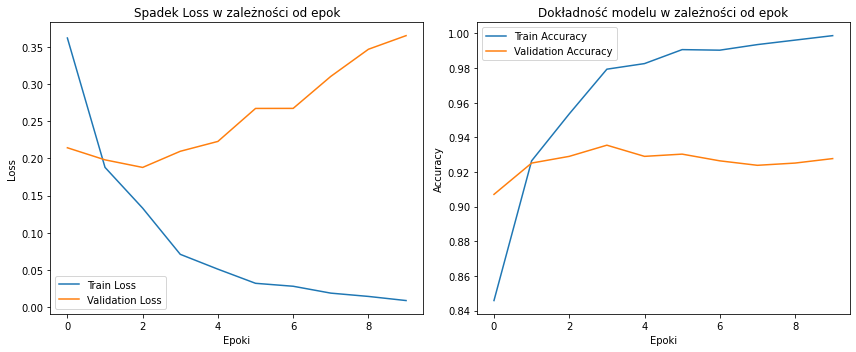

In [32]:
# Wizualizacja loss i accuracy
plt.figure(figsize = (12, 5))

# Straty
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Spadek Loss w zależności od epok')
plt.xlabel('Epoki')
plt.ylabel('Loss')
plt.legend()

# Dokładność
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Dokładność modelu w zależności od epok')
plt.xlabel('Epoki')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

Wizualizacja macierzy pomyłek

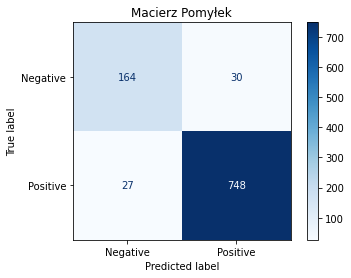

In [33]:
# Macierz pomyłek
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Macierz Pomyłek')
plt.show()

Ranking adresów z opiniami

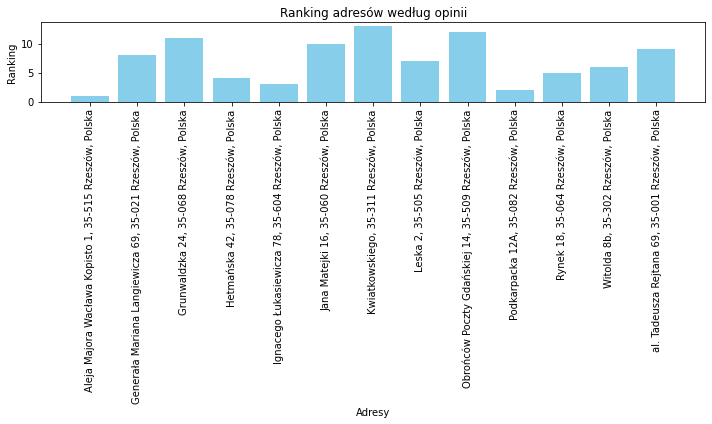

In [34]:
# Histogram rankingów
plt.figure(figsize = (10, 6))
plt.bar(merged_df.index, merged_df['rank_opinion'], color = 'skyblue')
plt.title('Ranking adresów według opinii')
plt.xlabel('Adresy')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### 5.2 Wnioski
**Dobra wydajność modelu**:
- Model bardzo dobrze poradził sobie z problemem analizy sentymentu w opiniach, co pozwoliło stworzyć ranking restauracji od najlepszej do najgorszej, który całkiem dobrze pokrywał się z oceną na stronie Google.
- Model poradził sobie dobrze, ponieważ zastosowano dwukierunkowe warstwy LSTM, które mogą uchwycić zależności w danych zarówno w przód, jak i w tył.
- Wykorzystanie warstwy osadzenia (embedding) umożliwiło reprezentację słów w sposób semantyczny, co zwiększyło skuteczność modelu.
- Warstwy Dropout pomogły ograniczyć przeuczenie, co zwiększyło ogólną generalizację modelu na danych testowych.

**Przetłumaczone dane**:
- Tłumaczenie tekstów na język angielski (jeśli dane wejściowe były w innym języku) pozwoliło na skuteczniejsze użycie dostępnych modeli językowych i lepszą reprezentację danych tekstowych.

**Dane wysokiej jakości**:
- Wstępne przetwarzanie danych, takie jak usunięcie brakujących wartości i normalizacja, przyczyniło się do poprawy wyników


#### 5.3 Możliwe ulepszenia
- **Rozbudowanie danych treningowych**:
Zwiększenie ilości danych poprzez augmentację danych tekstowych, np. synonimiczne zamiany słów czy tłumaczenie w obu kierunkach (PL -> EN i EN -> PL).
- **Fine-tuning modeli pretrenowanych**: 
Dostosowanie modelu językowego, np. BERT lub RoBERTa, zamiast trenowania modelu od podstaw.
- **Hiperparametry**:
Przeprowadzenie optymalizacji hiperparametrów, np. liczby jednostek LSTM, rozmiaru batcha czy współczynnika uczenia.
- **Regularizacja**:
Dodanie warstw Batch Normalization lub innego mechanizmu regularyzacji.
- **Analiza kontekstowa:**
Użycie zaawansowanych technik, takich jak Attention Mechanisms, aby lepiej uchwycić zależności kontekstowe w danych.